# 0 Infrastructure

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from pythonjsonlogger.defaults import time_default
from torch.utils.data import DataLoader, TensorDataset
from tqdm.auto import tqdm
import matplotlib.pyplot as plt
import numpy as np

device = torch.device("cpu")

torch.manual_seed(0)
# torch.backends.cuda.matmul.allow_tf32 = True
# torch.backends.cudnn.allow_tf32 = True
# torch.set_float32_matmul_precision('high')

def make_projection(D, d, device=device):
    A = torch.randn(D, d, device="cpu")
    Q, _ = torch.linalg.qr(A)
    Q = Q.to(device)
    return Q

# A 2d sample of n_points points that forms a swissroll
def sample_underlying_2d(n_points):
    theta = np.linspace(0, 4 * np.pi, n_points)
    r = theta / (4 * np.pi) * 2.0

    x = r * np.cos(theta)
    y = r * np.sin(theta)

    pts = np.stack([x, y], axis=1)

    pts += 0.02 * np.random.randn(*pts.shape)
    pts = torch.from_numpy(pts).float()
    return pts

C:\Users\57517\Desktop\Diffusion-ToyModel\.venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# 1 Coding for the model for training

## 1.1 The model itself

In [2]:
class MLP5(nn.Module):
    def __init__(self, x_dim, hidden_dim, out_dim, t_dim=None):
        """
        x_dim: D  (x is [B, D])
        t_dim: D  (t is [B, D]) by default
        """
        super().__init__()
        self.x_dim = x_dim
        self.t_dim = x_dim if t_dim is None else t_dim

        in_dim = self.x_dim + self.t_dim

        layers = []
        dims = [in_dim] + [hidden_dim] * 5 + [out_dim]
        for i in range(len(dims) - 2):
            layers.append(nn.Linear(dims[i], dims[i + 1]))
            layers.append(nn.ReLU(inplace=True))
        layers.append(nn.Linear(dims[-2], dims[-1]))
        self.net = nn.Sequential(*layers)

    def forward(self, x, t):
        """
        x: [B, D]
        t: [B, D]  (per-dim time)
           (also allows [B] or [B,1], which will be broadcast to [B, t_dim])
        """
        if t.dim() == 1:
            t = t.unsqueeze(-1)  # [B, 1]

        if t.dim() == 2 and t.shape[1] == 1 and self.t_dim != 1:
            # broadcast scalar time to per-dim time if user passes [B,1]
            t = t.expand(-1, self.t_dim)  # [B, t_dim]

        assert x.dim() == 2 and x.shape[1] == self.x_dim, f"x should be [B, {self.x_dim}]"
        assert t.dim() == 2 and t.shape[1] == self.t_dim, f"t should be [B, {self.t_dim}]"

        t = t.to(dtype=x.dtype, device=x.device)
        inp = torch.cat([x, t], dim=-1)  # [B, D + t_dim]
        return self.net(inp)

In [3]:
def train_toy(
    D=16,
    d=2,
    target_type="data",
    n_samples=20000,
    batch_size=1024,
    epochs=500,
    lr=1e-3,
):
    P = make_projection(D, d)  # [D, 2]
    x_hat = sample_underlying_2d(n_samples).to(device)  # [N, 2]
    x = x_hat @ P.t()  # This projects (places) the 2D data into D-dim data on a hyperplane. It still chooses an orthogonal basis.
    
    sigma = x.std() / 3.0
    print(f"Data std: {x.std().item():.4f}")
    print(f"Using sigma: {sigma.item():.4f}")
    print(f"Data shape: {x.shape}")

    dataset = TensorDataset(x)
    loader = DataLoader(dataset, batch_size=batch_size, shuffle=True, drop_last=True)

    model = MLP5(x_dim=D, hidden_dim=256, out_dim=D, t_dim=D).to(device)
    opt = torch.optim.Adam(model.parameters(), lr=lr)

    for epoch in tqdm(range(epochs), desc=f"Training D={D}, target={target_type}"):
        for step, (x_batch,) in enumerate(loader):
            x_1 = x_batch.to(device)  # [B, D]

            B = x_1.size(0)
            x_1 = x_1 / sigma

            #  t ~ Uniform(0,1), asynchronous time for each dim
            t = torch.rand((B, D), device=device)
            
            x_0 = torch.randn_like(x_1)
            x_t = t * x_1 + (1 - t) * x_0
            # [B, 2] * [B, 2] + [B, 2] * [B, 2]
            
            model_pred = model(x_t, t)

            if target_type == "data":
                dnorm = 1.0
                v_target = (x_1 - x_t) / dnorm
                v_pred = (model_pred - x_t) / dnorm
                loss = ((v_target - v_pred) ** 2).mean()

            elif target_type == "v":
                v_target = x_1 - x_0
                loss = ((v_target - model_pred) ** 2).mean()

            opt.zero_grad()
            loss.backward()
            opt.step()
        
        if (epoch + 1) % 50 == 0 or epoch == 0:
            print(f"[D={D}] Epoch {epoch + 1}/{epochs} | {target_type}-prediction loss: {loss.item():.4f}")

    return model, P, x_hat, x, sigma

## 1.2 Sampling algorithm

In [4]:
def compute_velocity(pred, x_t, t, target_type, eps=1e-4):
    """
    from data to velocity

    :param pred: model prediction (N, D)
    :param x_t: current noisy data (N, D)
    :param t: noise level (N, D)
    :param target_type: "data" or "v"
    :param eps: a safe epsilon for eliminating the possibiity of division by 0
    :return: velocity (N, D)
    """
    if target_type == "data":
        # if the model predicts x_1, the velocity is given by
        # v = (X_1 - X_t) / (1 - t)
        dist = torch.clamp(1.0-t, min = eps)
        vp = (pred - x_t) / dist
    elif target_type == "v":
        # if the model predicts v, just use v as velocity
        vp = pred
    else:
        raise ValueError(f"Unknown target_type: {target_type}")

    return vp

In [5]:
def show_point(x, P, x_true, target_type, D, cur_step=None):
    """
    visualization of the data (projected to 2d) and comparison to the real data
    """
    pred_2d = x @ P
    pred_2d_np = pred_2d.cpu().numpy()

    plt.figure(figsize=(8, 8))

    if x_true is not None:
        x_hat_np = x_true.cpu().numpy()
        plt.scatter(x_hat_np[:, 0], x_hat_np[:, 1],
                   s=10, alpha=0.4, c='blue', label="Real Data")

    plt.scatter(pred_2d_np[:, 0], pred_2d_np[:, 1],
               s=10, alpha=0.6, c='orange', label=f"Generated")

    plt.legend(fontsize=12)
    plt.title(f"Real vs Generated (D={D}, target={target_type})", fontsize=14)
    plt.xlabel('Dimension 1', fontsize=12)
    plt.ylabel('Dimension 2', fontsize=12)
    plt.axis("equal")
    plt.grid(True, alpha=0.3)
    plt.tight_layout()

    save_filename = (f"illustration/real_vs_gen_target_{target_type}_D_{D}_step_{cur_step}.png"
                    if cur_step is not None
                    else f"illustration/real_vs_gen_{target_type}_D{D}.png")
    plt.savefig(save_filename, dpi=200)
    plt.show()


def visualize_2d(model, P, t_schedule = None, target_type="data",
                       x_true=None, n_points=2000, steps=None, sigma=1.0):
    """
    Use asynchronous noise schedule to sample the data, and visualize them

    :param target_type: "data" or "v"
    :param steps: number of steps to denoise
    :param t_schedule: noise schedule
    NOTE: t_schedule and steps are not ALL None.
    - If t_schedule is NOT None and steps is NOT None, the real schedule is a linear interpolation of the t_schedule with "steps" steps
    - If t_schedule is NOT None and steps IS None, the real denoising schedule is t_schedule.
    - If t_schedule IS None and steps is NOT None, the real denoising schedule is a uniform homogenous schedule with "steps" steps.
    - If both of them are None, it will throw an exception.
    """
    model.eval()
    P = P.to(device)
    D, d = P.shape # data dimension
    if t_schedule is None:
        if steps is None:
            raise ValueError("one of t_schedule and steps must not be None!")
        else:
            t_schedule = torch.tensor([[i/steps for i in range(steps+1)] for _ in range(D)])
    M = t_schedule.shape[1] - 1 # schedule step

    x = torch.randn(n_points, D, device=device)
    if steps is None:
        steps = M

    print(f"Sampling with async schedule:")
    print(f"  D={D}, M={M}, steps={steps}")
    print(f"  Target type: {target_type}")
    print(f"  Generating {n_points} samples")

    for i in range(steps):
        with torch.no_grad():
            progress = i / steps

            # for steps > M, we linearly interpolate to get t_current
            idx_float = progress * M
            idx_low = int(idx_float)
            idx_high = min(idx_low + 1, M)
            weight = idx_float - idx_low

            t_current = torch.zeros(D, device=device)
            for dim in range(D):
                t_low = t_schedule[dim, idx_low]
                t_high = t_schedule[dim, idx_high]
                t_current[dim] = t_low * (1 - weight) + t_high * weight

            # also, linearly interpolate to get t_next
            if i < steps - 1:
                progress_next = (i + 1) / steps
                idx_float_next = progress_next * M
                idx_low_next = int(idx_float_next)
                idx_high_next = min(idx_low_next + 1, M)
                weight_next = idx_float_next - idx_low_next

                t_next = torch.zeros(D, device=device)
                for dim in range(D):
                    t_low_next = t_schedule[dim, idx_low_next]
                    t_high_next = t_schedule[dim, idx_high_next]
                    t_next[dim] = t_low_next * (1 - weight_next) + t_high_next * weight_next
            else:
                t_next = torch.ones(D, device=device)

            dt = t_next - t_current

            t = t_current.unsqueeze(0).expand(n_points, D)
            dt_expanded = dt.unsqueeze(0).expand(n_points, D)

            x_t = x
            pred = model(x_t, t)

            # from target_type calculate velocity
            vp = compute_velocity(pred, x_t, t, target_type)

            x = x_t + dt_expanded * vp

    print(f"Sampling complete!")

    # then this is the real visualization
    if x_true is not None:
        show_point(x * sigma, P, x_true, target_type, D)

    return x * sigma



## 1.3 Show the initial results of the generated model

Here, we show the result for the same settings with different scales and the method.


=== Training D=4, target=data ===
Data std: 0.5775
Using sigma: 0.1925
Data shape: torch.Size([20000, 4])


Training D=4, target=data:   0%|          | 1/500 [00:02<17:01,  2.05s/it]

[D=4] Epoch 1/500 | data-prediction loss: 1.9163


Training D=4, target=data:  10%|█         | 50/500 [00:19<02:40,  2.81it/s]

[D=4] Epoch 50/500 | data-prediction loss: 0.7690


Training D=4, target=data:  20%|██        | 100/500 [00:35<02:50,  2.35it/s]

[D=4] Epoch 100/500 | data-prediction loss: 0.7822


Training D=4, target=data:  30%|███       | 150/500 [00:50<01:41,  3.43it/s]

[D=4] Epoch 150/500 | data-prediction loss: 0.7412


Training D=4, target=data:  40%|████      | 200/500 [01:06<01:29,  3.33it/s]

[D=4] Epoch 200/500 | data-prediction loss: 0.7018


Training D=4, target=data:  50%|█████     | 250/500 [01:23<01:14,  3.35it/s]

[D=4] Epoch 250/500 | data-prediction loss: 0.6770


Training D=4, target=data:  60%|██████    | 300/500 [01:41<00:59,  3.37it/s]

[D=4] Epoch 300/500 | data-prediction loss: 0.6824


Training D=4, target=data:  70%|███████   | 350/500 [01:56<00:44,  3.35it/s]

[D=4] Epoch 350/500 | data-prediction loss: 0.7938


Training D=4, target=data:  80%|████████  | 400/500 [02:12<00:30,  3.33it/s]

[D=4] Epoch 400/500 | data-prediction loss: 0.7368


Training D=4, target=data:  90%|█████████ | 450/500 [02:33<00:20,  2.47it/s]

[D=4] Epoch 450/500 | data-prediction loss: 0.7054


Training D=4, target=data: 100%|██████████| 500/500 [02:53<00:00,  2.88it/s]

[D=4] Epoch 500/500 | data-prediction loss: 0.6982
Sampling with async schedule:
  D=4, M=100, steps=100
  Target type: data
  Generating 20000 samples


Sampling complete!


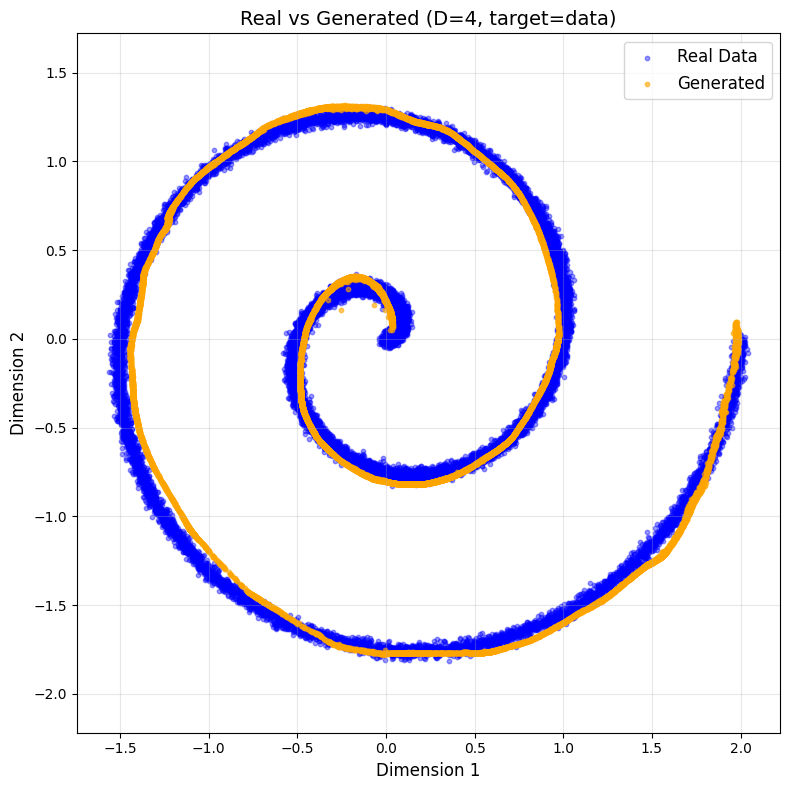


=== Training D=4, target=v ===
Data std: 0.5774
Using sigma: 0.1925
Data shape: torch.Size([20000, 4])


Training D=4, target=v:   0%|          | 1/500 [00:00<02:26,  3.40it/s]

[D=4] Epoch 1/500 | v-prediction loss: 3.8726


Training D=4, target=v:  10%|█         | 50/500 [00:21<02:57,  2.53it/s]

[D=4] Epoch 50/500 | v-prediction loss: 1.8178


Training D=4, target=v:  20%|██        | 100/500 [00:48<04:51,  1.37it/s]

[D=4] Epoch 100/500 | v-prediction loss: 1.9108


Training D=4, target=v:  30%|███       | 150/500 [01:19<02:08,  2.71it/s]

[D=4] Epoch 150/500 | v-prediction loss: 1.6633


Training D=4, target=v:  40%|████      | 200/500 [01:40<02:23,  2.09it/s]

[D=4] Epoch 200/500 | v-prediction loss: 1.7713


Training D=4, target=v:  50%|█████     | 250/500 [01:55<01:25,  2.92it/s]

[D=4] Epoch 250/500 | v-prediction loss: 1.5565


Training D=4, target=v:  60%|██████    | 300/500 [02:10<01:05,  3.04it/s]

[D=4] Epoch 300/500 | v-prediction loss: 1.5530


Training D=4, target=v:  70%|███████   | 350/500 [02:24<00:44,  3.37it/s]

[D=4] Epoch 350/500 | v-prediction loss: 1.4347


Training D=4, target=v:  80%|████████  | 400/500 [02:41<00:28,  3.54it/s]

[D=4] Epoch 400/500 | v-prediction loss: 1.4674


Training D=4, target=v:  90%|█████████ | 450/500 [02:56<00:13,  3.63it/s]

[D=4] Epoch 450/500 | v-prediction loss: 1.4359


Training D=4, target=v: 100%|██████████| 500/500 [03:12<00:00,  2.60it/s]

[D=4] Epoch 500/500 | v-prediction loss: 1.6471
Sampling with async schedule:
  D=4, M=100, steps=100
  Target type: v
  Generating 20000 samples


Sampling complete!


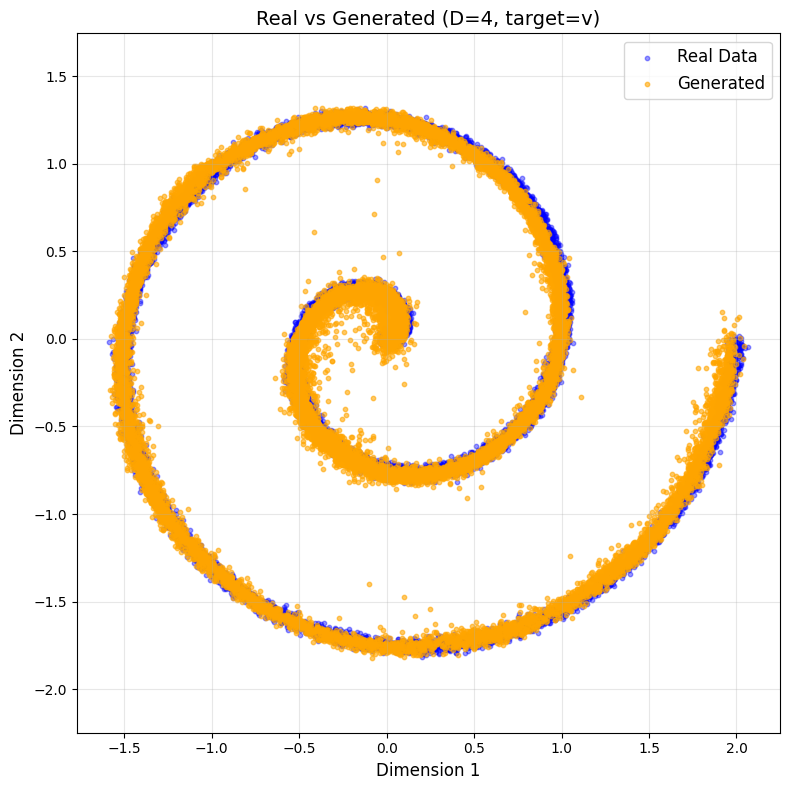


=== Training D=16, target=data ===
Data std: 0.2887
Using sigma: 0.0962
Data shape: torch.Size([20000, 16])


Training D=16, target=data:   0%|          | 1/500 [00:00<02:51,  2.91it/s]

[D=16] Epoch 1/500 | data-prediction loss: 1.1487


Training D=16, target=data:  10%|█         | 50/500 [00:19<02:20,  3.19it/s]

[D=16] Epoch 50/500 | data-prediction loss: 0.0880


Training D=16, target=data:  20%|██        | 100/500 [00:35<01:57,  3.42it/s]

[D=16] Epoch 100/500 | data-prediction loss: 0.0773


Training D=16, target=data:  30%|███       | 150/500 [00:50<01:40,  3.48it/s]

[D=16] Epoch 150/500 | data-prediction loss: 0.0679


Training D=16, target=data:  40%|████      | 200/500 [01:05<01:28,  3.40it/s]

[D=16] Epoch 200/500 | data-prediction loss: 0.0586


Training D=16, target=data:  50%|█████     | 250/500 [01:20<01:14,  3.38it/s]

[D=16] Epoch 250/500 | data-prediction loss: 0.0445


Training D=16, target=data:  60%|██████    | 300/500 [01:35<01:00,  3.29it/s]

[D=16] Epoch 300/500 | data-prediction loss: 0.0405


Training D=16, target=data:  70%|███████   | 350/500 [01:51<00:45,  3.29it/s]

[D=16] Epoch 350/500 | data-prediction loss: 0.0379


Training D=16, target=data:  80%|████████  | 400/500 [02:06<00:29,  3.33it/s]

[D=16] Epoch 400/500 | data-prediction loss: 0.0280


Training D=16, target=data:  90%|█████████ | 450/500 [02:21<00:15,  3.15it/s]

[D=16] Epoch 450/500 | data-prediction loss: 0.0312


Training D=16, target=data: 100%|██████████| 500/500 [02:36<00:00,  3.19it/s]

[D=16] Epoch 500/500 | data-prediction loss: 0.0300
Sampling with async schedule:
  D=16, M=100, steps=100
  Target type: data
  Generating 20000 samples


Sampling complete!


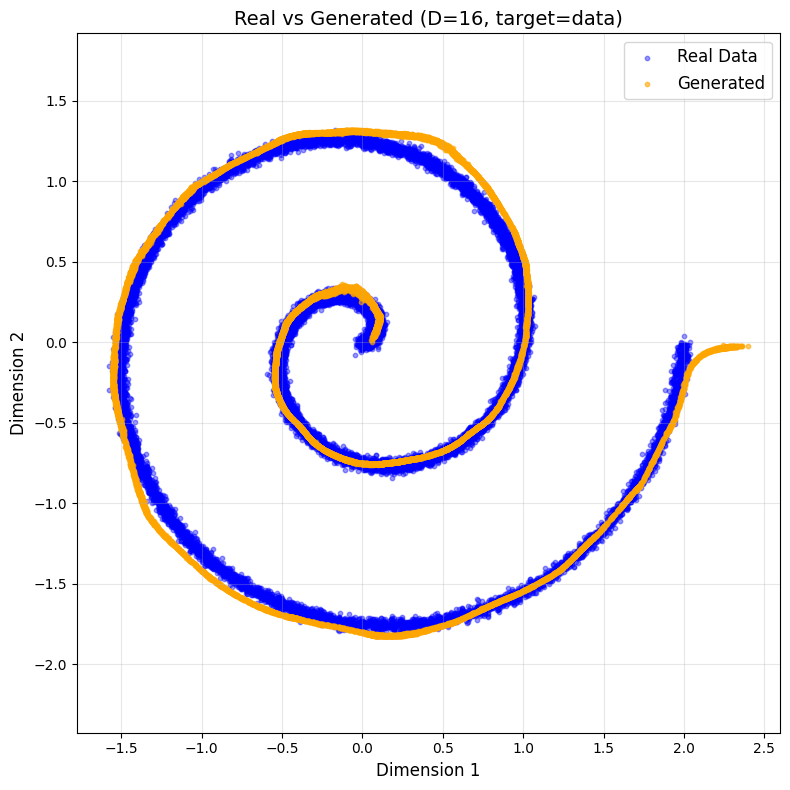


=== Training D=16, target=v ===
Data std: 0.2887
Using sigma: 0.0962
Data shape: torch.Size([20000, 16])


Training D=16, target=v:   0%|          | 1/500 [00:00<03:23,  2.45it/s]

[D=16] Epoch 1/500 | v-prediction loss: 2.4904


Training D=16, target=v:  10%|█         | 50/500 [00:13<02:09,  3.49it/s]

[D=16] Epoch 50/500 | v-prediction loss: 0.8131


Training D=16, target=v:  20%|██        | 100/500 [00:28<02:07,  3.15it/s]

[D=16] Epoch 100/500 | v-prediction loss: 0.5659


Training D=16, target=v:  30%|███       | 150/500 [00:43<01:39,  3.51it/s]

[D=16] Epoch 150/500 | v-prediction loss: 0.4872


Training D=16, target=v:  40%|████      | 200/500 [00:58<01:24,  3.55it/s]

[D=16] Epoch 200/500 | v-prediction loss: 0.4275


Training D=16, target=v:  50%|█████     | 250/500 [01:12<01:09,  3.60it/s]

[D=16] Epoch 250/500 | v-prediction loss: 0.4102


Training D=16, target=v:  60%|██████    | 300/500 [01:27<01:04,  3.10it/s]

[D=16] Epoch 300/500 | v-prediction loss: 0.3630


Training D=16, target=v:  70%|███████   | 350/500 [01:41<00:41,  3.62it/s]

[D=16] Epoch 350/500 | v-prediction loss: 0.3440


Training D=16, target=v:  80%|████████  | 400/500 [01:56<00:27,  3.58it/s]

[D=16] Epoch 400/500 | v-prediction loss: 0.3331


Training D=16, target=v:  90%|█████████ | 450/500 [02:10<00:13,  3.59it/s]

[D=16] Epoch 450/500 | v-prediction loss: 0.3218


Training D=16, target=v: 100%|██████████| 500/500 [02:25<00:00,  3.45it/s]

[D=16] Epoch 500/500 | v-prediction loss: 0.2960
Sampling with async schedule:
  D=16, M=100, steps=100
  Target type: v
  Generating 20000 samples


Sampling complete!


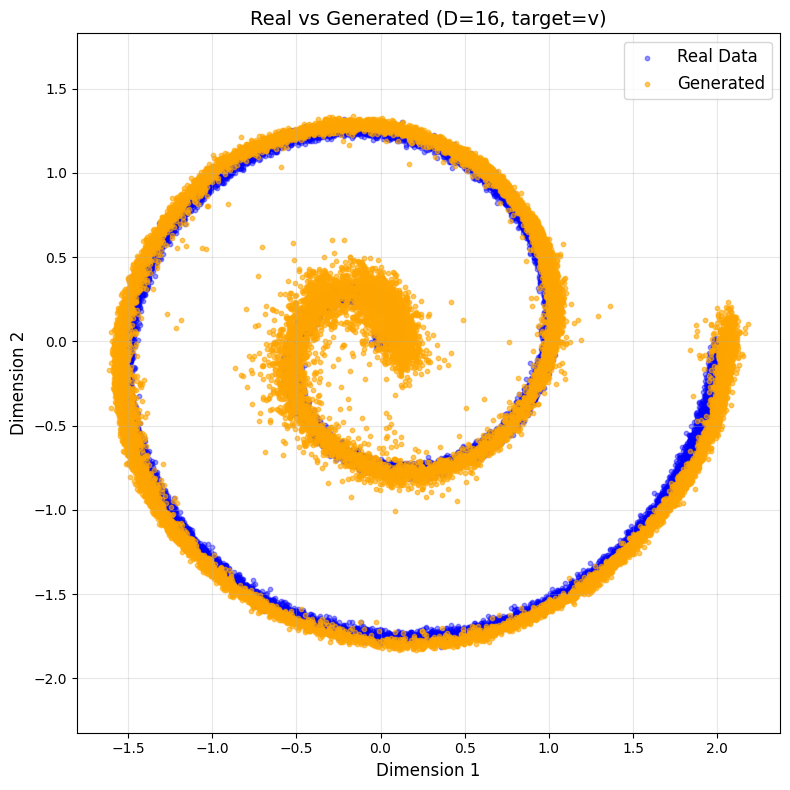


=== Training D=512, target=data ===
Data std: 0.0510
Using sigma: 0.0170
Data shape: torch.Size([20000, 512])


Training D=512, target=data:   0%|          | 1/500 [00:00<05:03,  1.64it/s]

[D=512] Epoch 1/500 | data-prediction loss: 0.8004


Training D=512, target=data:  10%|█         | 50/500 [00:30<04:39,  1.61it/s]

[D=512] Epoch 50/500 | data-prediction loss: 0.0171


Training D=512, target=data:  20%|██        | 100/500 [01:02<04:16,  1.56it/s]

[D=512] Epoch 100/500 | data-prediction loss: 0.0165


Training D=512, target=data:  30%|███       | 150/500 [01:33<03:43,  1.57it/s]

[D=512] Epoch 150/500 | data-prediction loss: 0.0127


Training D=512, target=data:  40%|████      | 200/500 [02:05<03:07,  1.60it/s]

[D=512] Epoch 200/500 | data-prediction loss: 0.0119


Training D=512, target=data:  50%|█████     | 250/500 [02:36<02:32,  1.64it/s]

[D=512] Epoch 250/500 | data-prediction loss: 0.0126


Training D=512, target=data:  60%|██████    | 300/500 [03:08<02:10,  1.54it/s]

[D=512] Epoch 300/500 | data-prediction loss: 0.0123


Training D=512, target=data:  70%|███████   | 350/500 [03:39<01:31,  1.64it/s]

[D=512] Epoch 350/500 | data-prediction loss: 0.0076


Training D=512, target=data:  80%|████████  | 400/500 [04:11<01:01,  1.64it/s]

[D=512] Epoch 400/500 | data-prediction loss: 0.0062


Training D=512, target=data:  90%|█████████ | 450/500 [04:42<00:31,  1.61it/s]

[D=512] Epoch 450/500 | data-prediction loss: 0.0060


Training D=512, target=data: 100%|██████████| 500/500 [05:13<00:00,  1.59it/s]

[D=512] Epoch 500/500 | data-prediction loss: 0.0056
Sampling with async schedule:
  D=512, M=100, steps=100
  Target type: data
  Generating 20000 samples


Sampling complete!


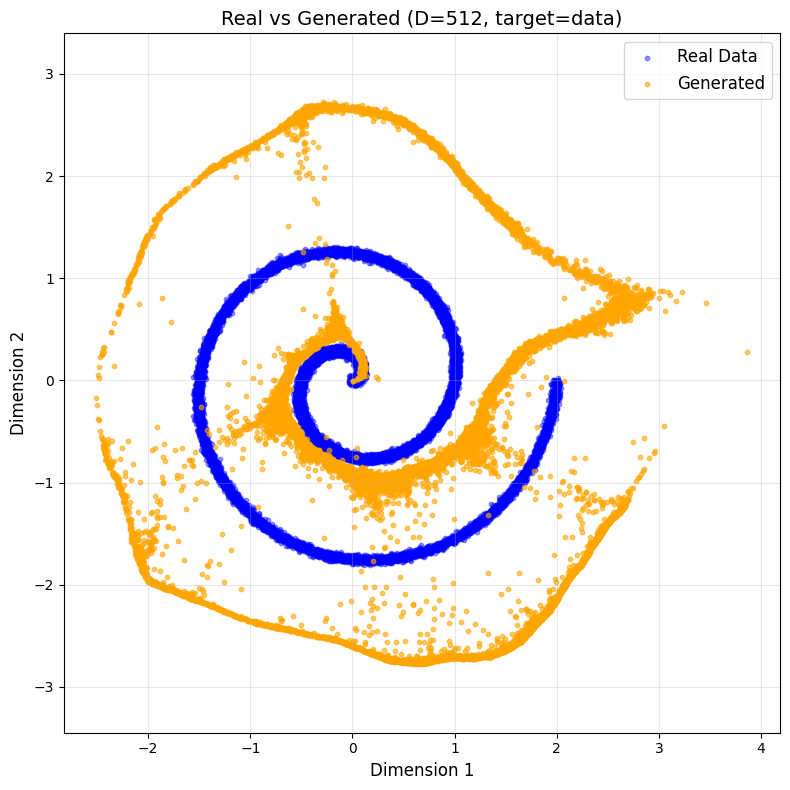


=== Training D=512, target=v ===
Data std: 0.0510
Using sigma: 0.0170
Data shape: torch.Size([20000, 512])


Training D=512, target=v:   0%|          | 1/500 [00:00<04:45,  1.75it/s]

[D=512] Epoch 1/500 | v-prediction loss: 2.0066


Training D=512, target=v:  10%|█         | 50/500 [00:30<04:31,  1.66it/s]

[D=512] Epoch 50/500 | v-prediction loss: 1.0260


Training D=512, target=v:  20%|██        | 100/500 [01:00<03:57,  1.69it/s]

[D=512] Epoch 100/500 | v-prediction loss: 1.0245


Training D=512, target=v:  30%|███       | 150/500 [01:31<03:28,  1.68it/s]

[D=512] Epoch 150/500 | v-prediction loss: 1.0163


Training D=512, target=v:  40%|████      | 200/500 [02:01<02:58,  1.68it/s]

[D=512] Epoch 200/500 | v-prediction loss: 1.0177


Training D=512, target=v:  50%|█████     | 250/500 [02:32<02:36,  1.59it/s]

[D=512] Epoch 250/500 | v-prediction loss: 1.0101


Training D=512, target=v:  60%|██████    | 300/500 [03:02<02:03,  1.62it/s]

[D=512] Epoch 300/500 | v-prediction loss: 1.0052


Training D=512, target=v:  70%|███████   | 350/500 [03:34<01:35,  1.58it/s]

[D=512] Epoch 350/500 | v-prediction loss: 0.9956


Training D=512, target=v:  80%|████████  | 400/500 [04:04<00:59,  1.69it/s]

[D=512] Epoch 400/500 | v-prediction loss: 0.9953


Training D=512, target=v:  90%|█████████ | 450/500 [04:35<00:29,  1.67it/s]

[D=512] Epoch 450/500 | v-prediction loss: 0.9870


Training D=512, target=v: 100%|██████████| 500/500 [05:06<00:00,  1.63it/s]

[D=512] Epoch 500/500 | v-prediction loss: 0.9841
Sampling with async schedule:
  D=512, M=100, steps=100
  Target type: v
  Generating 20000 samples


Sampling complete!


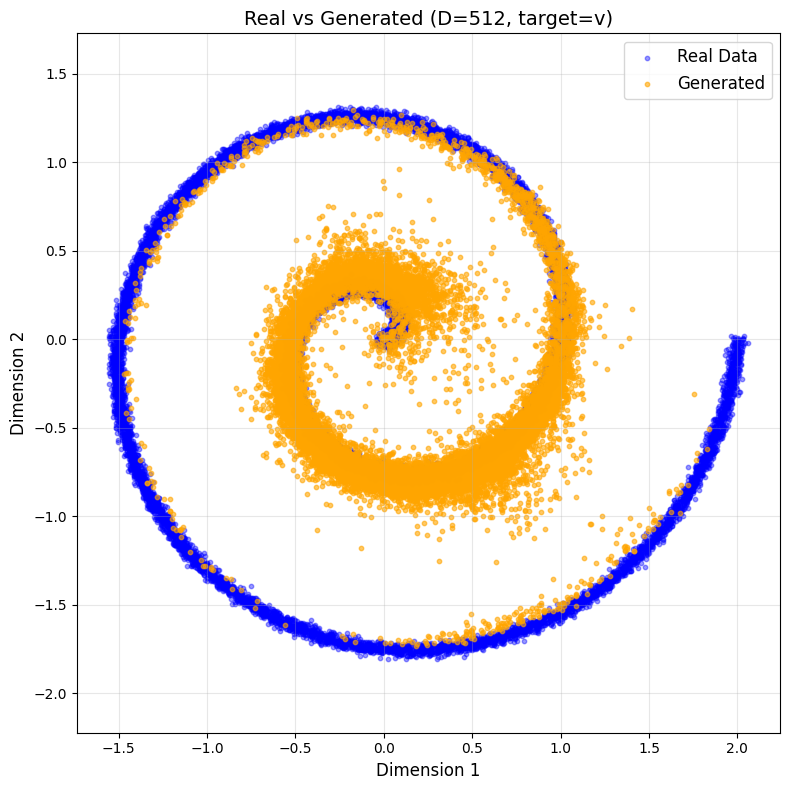

In [6]:
Ds = [4, 16, 512]
target_types = ["data", "v"]

for D in Ds:
    for tt in target_types:
        print(f"\n=== Training D={D}, target={tt} ===")
        model, P, x_hat, x, sigma = train_toy(
            D=D,
            d=2,
            target_type=tt,
            n_samples=20000,
            batch_size=1024,
            epochs=500,
            lr=1e-3,
        )
        visualize_2d(model, P, n_points=20000, target_type=tt, steps=100, x_true=x_hat, sigma=sigma)

# 2 Calculating the loss.

Now we calculate the loss and look at the gradient. We look at the loss value for different $t$ (it is a scalar now).



# 2.1 target predicting data.

In [7]:
model, P, x_hat, x, sigma = train_toy(
    D=4,
    d=2,
    target_type="data",
    n_samples=20000,
    batch_size=1024,
    epochs=500,
    lr=1e-3,
)

Data std: 0.5772
Using sigma: 0.1924
Data shape: torch.Size([20000, 4])


Training D=4, target=data:   0%|          | 1/500 [00:00<03:32,  2.35it/s]

[D=4] Epoch 1/500 | data-prediction loss: 2.1667


Training D=4, target=data:  10%|█         | 50/500 [00:13<02:04,  3.63it/s]

[D=4] Epoch 50/500 | data-prediction loss: 0.7424


Training D=4, target=data:  20%|██        | 100/500 [00:27<01:54,  3.50it/s]

[D=4] Epoch 100/500 | data-prediction loss: 0.8285


Training D=4, target=data:  30%|███       | 150/500 [00:41<01:37,  3.60it/s]

[D=4] Epoch 150/500 | data-prediction loss: 0.6587


Training D=4, target=data:  40%|████      | 200/500 [00:56<01:31,  3.27it/s]

[D=4] Epoch 200/500 | data-prediction loss: 0.7152


Training D=4, target=data:  50%|█████     | 250/500 [01:10<01:07,  3.69it/s]

[D=4] Epoch 250/500 | data-prediction loss: 0.6194


Training D=4, target=data:  60%|██████    | 300/500 [01:24<00:55,  3.63it/s]

[D=4] Epoch 300/500 | data-prediction loss: 0.5939


Training D=4, target=data:  70%|███████   | 350/500 [01:38<00:41,  3.64it/s]

[D=4] Epoch 350/500 | data-prediction loss: 0.6497


Training D=4, target=data:  80%|████████  | 400/500 [01:52<00:27,  3.61it/s]

[D=4] Epoch 400/500 | data-prediction loss: 0.5913


Training D=4, target=data:  90%|█████████ | 450/500 [02:08<00:15,  3.27it/s]

[D=4] Epoch 450/500 | data-prediction loss: 0.5595


Training D=4, target=data: 100%|██████████| 500/500 [02:22<00:00,  3.50it/s]

[D=4] Epoch 500/500 | data-prediction loss: 0.6832


In [8]:
N = 50
losses = []
grads = []
for t_scalar in [i/N for i in range(N+1)]:
    sigma = x.std() / 3.0
    t_torch = torch.tensor(t_scalar, requires_grad=True)
    t = t_torch.expand_as(x)
    B = x.size(0)
    x_1 = x / sigma

    x_0 = torch.randn_like(x_1)
    x_t = t * x_1 + (1 - t) * x_0
    # [B, 2] * [B, 2] + [B, 2] * [B, 2]

    model_pred = model(x_t, t)
    v_target = x_1 - x_0
    loss = ((v_target - model_pred) ** 2).mean()
    loss2 = torch.clone(loss)
    losses.append(loss2.detach().numpy())
    loss.backward()
    grads.append(t_torch.grad.detach().numpy())

We look at the loss and grad value for different $t$ (it is a scalar now)

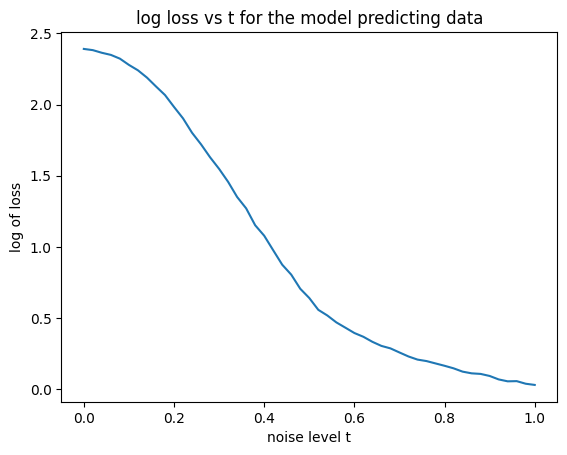

In [9]:
from matplotlib import pyplot as plt
import math
plt.title("log loss vs t for the model predicting data")
plt.xlabel("noise level t")
plt.ylabel("log of loss")
plt.plot([i/N for i in range(N+1)], [np.log(loss) for loss in losses])
plt.savefig("illustration/losses_vs_t_data.png")

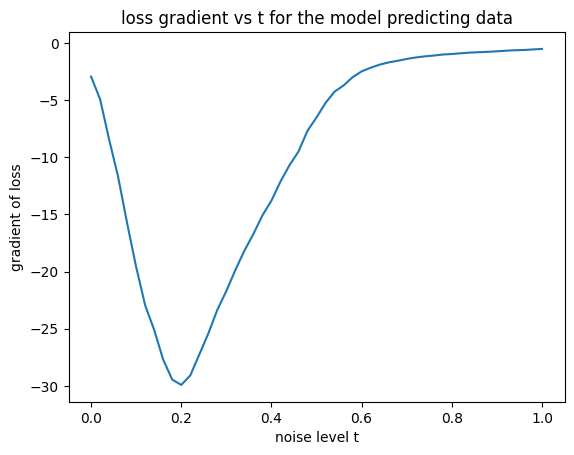

In [10]:
from matplotlib import pyplot as plt
import math
plt.title("loss gradient vs t for the model predicting data")
plt.xlabel("noise level t")
plt.ylabel("gradient of loss")
plt.plot([i/N for i in range(N+1)], grads)
plt.savefig("illustration/grads_vs_t_data.png")

# 2.2 Target predicting v

In [11]:
model, P, x_hat, x, sigma = train_toy(
    D=4,
    d=2,
    target_type="v",
    n_samples=20000,
    batch_size=1024,
    epochs=500,
    lr=1e-3,
)

Data std: 0.5767
Using sigma: 0.1922
Data shape: torch.Size([20000, 4])


Training D=4, target=v:   0%|          | 1/500 [00:00<02:12,  3.78it/s]

[D=4] Epoch 1/500 | v-prediction loss: 3.8411


Training D=4, target=v:  10%|█         | 50/500 [00:13<02:18,  3.25it/s]

[D=4] Epoch 50/500 | v-prediction loss: 1.8520


Training D=4, target=v:  20%|██        | 100/500 [00:27<02:01,  3.28it/s]

[D=4] Epoch 100/500 | v-prediction loss: 1.6662


Training D=4, target=v:  30%|███       | 150/500 [00:41<01:36,  3.64it/s]

[D=4] Epoch 150/500 | v-prediction loss: 1.5266


Training D=4, target=v:  40%|████      | 200/500 [00:55<01:25,  3.50it/s]

[D=4] Epoch 200/500 | v-prediction loss: 1.6022


Training D=4, target=v:  50%|█████     | 250/500 [01:09<01:08,  3.64it/s]

[D=4] Epoch 250/500 | v-prediction loss: 1.4990


Training D=4, target=v:  60%|██████    | 300/500 [01:24<01:00,  3.32it/s]

[D=4] Epoch 300/500 | v-prediction loss: 1.4636


Training D=4, target=v:  70%|███████   | 350/500 [01:38<00:40,  3.70it/s]

[D=4] Epoch 350/500 | v-prediction loss: 1.6138


Training D=4, target=v:  80%|████████  | 400/500 [01:52<00:28,  3.54it/s]

[D=4] Epoch 400/500 | v-prediction loss: 1.4077


Training D=4, target=v:  90%|█████████ | 450/500 [02:06<00:14,  3.55it/s]

[D=4] Epoch 450/500 | v-prediction loss: 1.6919


Training D=4, target=v: 100%|██████████| 500/500 [02:20<00:00,  3.55it/s]

[D=4] Epoch 500/500 | v-prediction loss: 1.4568


In [12]:
N = 50
losses = []
grads = []
for t_scalar in [i/N for i in range(N+1)]:
    sigma = x.std() / 3.0
    t_torch = torch.tensor(t_scalar, requires_grad=True)
    t = t_torch.expand_as(x)
    B = x.size(0)
    x_1 = x / sigma

    x_0 = torch.randn_like(x_1)
    x_t = t * x_1 + (1 - t) * x_0
    # [B, 2] * [B, 2] + [B, 2] * [B, 2]

    model_pred = model(x_t, t)
    v_target = x_1 - x_0
    loss = ((v_target - model_pred) ** 2).mean()
    loss2 = torch.clone(loss)
    losses.append(loss2.detach().numpy())
    loss.backward()
    grads.append(t_torch.grad.detach().numpy())

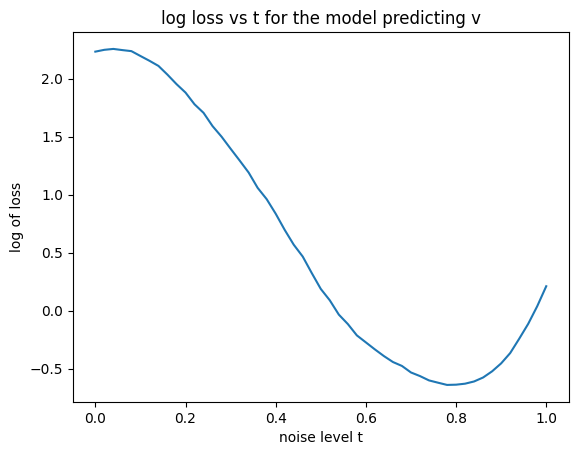

In [13]:
from matplotlib import pyplot as plt
import math
plt.title("log loss vs t for the model predicting v")
plt.xlabel("noise level t")
plt.ylabel("log of loss")
plt.plot([i/N for i in range(N+1)], [np.log(loss) for loss in losses])
plt.savefig("illustration/losses_vs_t_v.png")

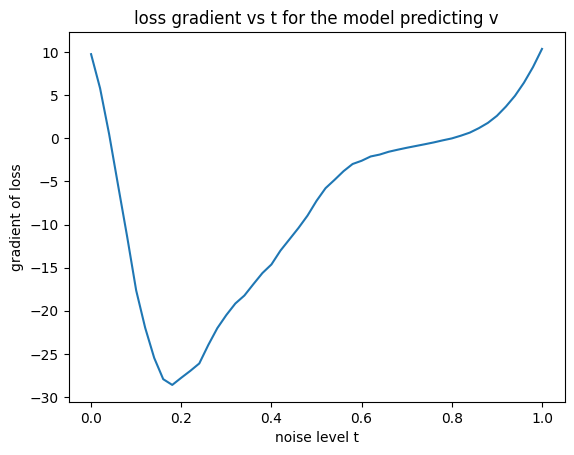

In [14]:
from matplotlib import pyplot as plt
import math
plt.title("loss gradient vs t for the model predicting v")
plt.xlabel("noise level t")
plt.ylabel("gradient of loss")
plt.plot([i/N for i in range(N+1)], grads)
plt.savefig("illustration/grads_vs_t_data.png")

# 3 Learning and optimizing the schedule

Now we are going to minimize the target function if we are predicting $h(X_t, t) = \mathbb E[X_1|X_t, t]$, we should minimize

$$\int_{t} \sum_{j}\frac{t_j\mathrm dt_j}{(1-t_j)^3}\mathbb E[(h(X_t,t)-\mathbb E[X_1|X_t,t])^2].$$

We use a discretizaion to calculate the this interval. That is, if out noise schedure is $t_{j,T}$, we calculate
$$L(t)=\sum_T \sum_{j}\frac{(t_{j,T}-t_{j,T-1})\cdot t_{j,T}}{(1-t_{j,T})^3}\mathbb E[(h(X_t,t)-\mathbb E[X_1|X_t,t])]^2.$$

In practice, when we have $N$ samples, we do the following:
$$L(t)=\sum_T \sum_{j}\frac{(t_{j,T}-t_{j,T-1})\cdot t_{j,T}}{\color{red}(1-t_{j,T})^3}\cdot \frac{1}{N}\sum_{s=1}^N (h(X_t^{(s)},t)-X_1^{(s)})^2.$$

Similarly, if we are predicting the speed, i.e., $h(X_t,t)=\mathbb E[X_1-X_0|X_t, t]$, the weight for the $L(T)$ should be (the weight is different)

$$L(t)=\sum_T \sum_{j}\frac{(t_{j,T}-t_{j,T-1})\cdot t_{j,T}}{\color{red}{1-t_{j,T}}}\cdot \frac{1}{N}\sum_{s=1}^N (h(X_t^{(s)},t)-X_1^{(s)})^2.$$


The per-dim noise schedule is $t\in\mathbb R^{(M+1)\times d}$, where $d$ is the number dimension of the data and $M$ is the step. The noise schedule $t$ initially are given by linear: $t_{i}$ is a all $i/M$ vector for $i=0,1,\dots,N$. We want the following holds during the training process:

- For any $0\le i\le M$, the total sum of $t_i$ is $i\cdot d/M$. Specifically, $t_0$ is an all-zero vector and $t_1$ is all-one vector.

We do **NOT** have a good idea for splitting the intervals. We just use the uniform splitting here.

- For any $1\le i\le M-1$ and $1\le j\le d$, $t_{i-1,j}\le t_{i,j}\le t_{i+1,j}$.

Our algorithm is as follows:

- Calculate $L(T)=\sum_i \sum_{j}\frac{(t_{i,j}-t_{i-1,j})\cdot t_{i,j}}{(1-t_{i,j})^3}\cdot\frac{1}{N}\sum_{s=1}^N(h_j(X_t^{(s)},t)-{X_t^{(s)}}_j)^2.$ Here, $X^{(s)}$ denotes the $s$th sample. Since we are NOT using the same noise level per dimension, for $j$th dimension, it is given as $X_j = (1-t_{i,j}) \mathcal N(0,1) + t_{i,j} {X_1}_j$ be the noisy sample with noise level (per dimension) $t_{i,j}$. You can choose the random $\mathcal N(0,1)$ to be fixed or not fixed during the training process.
- Looping the followings for $n$ epochs:
- - For each odd number $i$ (it can be done in batch), the gradient of $g_i = \partial L/\partial t_{i}$. $g_i'$ is the vector projecting $g_i$ to the hyperplane $t_{i,1}+\dots+t_{i,d}=0$. Then, we update this noise level by a gradient descent: $t_i' = t_i -\lambda \cdot g_i$, then clamp every coordinate monotonically: $t_{i-1,j}\le t_{i,j}\le t_{i+1,j}$. Here, $\lambda$ is the learning rate.
- - For each even number $i$, do the same.

Then you can get an updated $t$.

## 3.1 Observe the visualization when targeting data

In [15]:
def compute_weight(t, dt, target_type, eps=1e-3):
    """
    calculate the weight for integral.

    :param t: noise schedule (D,)
    :param dt: difference of noise schedule (D,)
    :param target_type: "data" or "v"
    :param eps: a small number to prevert division of zero
    :return: the weight (D,)
    """
    clamped_1mt = torch.clamp(1.-t, min = eps)
    if target_type == "data":
        # for X_1: weight = t / (1-t)^3
        weight = dt * t / (clamped_1mt ** 3)
    elif target_type == "v":
        # for velocity: weight = t / (1-t)
        weight = dt * t / clamped_1mt
    else:
        raise ValueError(f"Unknown target_type: {target_type}")

    return weight

def total_loss(x_1, t, model, target_type="data", x_0=None,
                    eps=1e-3, safe_ratio=1.0, weight_max_cap = 10.0, weight_min_cap = 0.1):
    """
    Calculate the Girsanov loss

    :param target_type: "data" or "v"
    """
    N, D = x_1.shape
    M = t.shape[1] - 1

    if x_0 is None:
        x_0 = torch.randn_like(x_1)

    total = 0.0
    max_i = int(safe_ratio * M)

    for i in range(1, max_i):
        t_i = t[:, i]
        t_i_prev = t[:, i-1]

        t_expanded = t_i.unsqueeze(0).expand(N, D)
        x_t = t_expanded * x_1 + (1 - t_expanded) * x_0

        with torch.no_grad():
            pred = model(x_t, t_expanded)

        # using target_type to calculate MSE
        if target_type == "data":
            # for X_1
            mse_per_dim = ((pred - x_1) ** 2).mean(dim=0)
        elif target_type == "v":
            # for velocity.
            # In rectified flow，v = X_1 - X_0
            true_v = x_1 - x_0
            mse_per_dim = ((pred - true_v) ** 2).mean(dim=0)

        dt = t_i - t_i_prev

        # calculating the weight using target_type
        weight = compute_weight(t_i, dt, target_type, eps)
        weight = torch.clamp(weight, max = weight_max_cap, min = weight_min_cap)

        total += (mse_per_dim * weight).sum()

    return total


def project_gradient_to_hyperplane(grad):
    return grad - grad.mean()


def grad_update(x_0, x_1, t, model, target_type, parity,
                learning_rate=0.1, eps=1e-3, safe_ratio=1.0,
                weight_max_cap = 10, weight_min_cap = 0.1):
    N, D = x_1.shape
    M = t.shape[1] - 1
    t_new = t.clone()

    max_idx = int(safe_ratio * M)

    if parity == 0:
        indices = list(range(2, max_idx, 2))
    else:
        indices = list(range(1, max_idx, 2))

    if len(indices) == 0:
        return t_new

    for idx in indices:
        t_var = t[:, idx].clone().detach().requires_grad_(True)
        t_i_prev = t[:, idx - 1]

        t_expanded = t_var.unsqueeze(0).expand(N, D)
        x_t = t_expanded * x_1 + (1 - t_expanded) * x_0

        pred = model(x_t, t_expanded)

        # from target_type calculate MSE
        if target_type == "data":
            mse_per_dim = ((pred - x_1) ** 2).mean(dim=0)
        elif target_type == "v":
            true_v = x_1 - x_0
            mse_per_dim = ((pred - true_v) ** 2).mean(dim=0)

        dt = t_var - t_i_prev

        # from target_type calculate weight
        weight = compute_weight(t_var, dt, target_type, eps)
        weight = torch.clamp(weight, max=weight_max_cap, min = weight_min_cap)

        loss = (mse_per_dim * weight).sum()
        loss.backward()

        grad = t_var.grad
        grad_projected = project_gradient_to_hyperplane(grad)

        with torch.no_grad():
            t_new[:, idx] = t_var - learning_rate * grad_projected

            current_sum = t_new[:, idx].sum()
            target_sum = idx * D / M
            correction = (target_sum - current_sum) / D
            t_new[:, idx] = t_new[:, idx] + correction

            if idx > 0:
                t_new[:, idx] = torch.maximum(t_new[:, idx], t_new[:, idx-1] + 1e-4)
            if idx < M:
                t_new[:, idx] = torch.minimum(t_new[:, idx], t_new[:, idx+1] - 1e-4)

    return t_new


def learning(x_1, M, model, target_type="data", epoch=100,
                  learning_rate=0.1, fixed_x0=True, eps=1e-3,
                  subsample=2000, loss_freq=10, safe_ratio=1.0,
                  weight_max_cap = 10.0, weight_min_cap = 0.1):
    """
    A safe optimizing for the schedule. Can do both target_type
    It is quicker.
    :param x_1: true data
    :param M: number of steps. Notice that the output is tensor of shape (D, M+1)!
    :param target_type: "data" or "v"
    :param fixed_x0: bool, check whether x_0 is using the fixed one throughout the learning process
    :param eps: float, still to eliminate division by zero
    :param subsample: int, subsample the data
    :param loss_freq: int, how often to compute loss
    :param safe_ratio: float, to get rid of exploding of the gradient, we don't update the data when we update the last (1-safe_ratio) portion of data.
    """
    N_samples, D = x_1.shape

    if subsample is not None and subsample < N_samples:
        indices = torch.randperm(N_samples)[:subsample]
        x_1_sub = x_1[indices]
        print(f"Using {subsample}/{N_samples} samples for optimization")
    else:
        x_1_sub = x_1
        subsample = N_samples

    t = torch.zeros(D, M + 1, device=x_1.device)
    for i in range(M + 1):
        t[:, i] = i / M

    if fixed_x0:
        x_0 = torch.randn_like(x_1_sub)
    else:
        x_0 = None

    loss_history = []

    print(f"Target type: {target_type}")
    if target_type == "data":
        print(f"  Model predicts: X_1")
        print(f"  Weight formula: t / (1-t)³")
    elif target_type == "v":
        print(f"  Model predicts: velocity v")
        print(f"  Weight formula: t / (1-t)")

    print(f"Schedule shape: {t.shape} (D={D}, M={M})")
    print(f"Safe ratio: {safe_ratio} (optimizing only first {int(safe_ratio*M)}/{M} steps)")
    print(f"Loss frequency: every {loss_freq} epochs")

    initial_loss = total_loss(x_1_sub, t, model, target_type, x_0, eps, safe_ratio)
    print(f"Initial loss: {initial_loss.item():.6f}\n")
    loss_history.append(initial_loss.item())

    for ep in tqdm(range(epoch), desc="Optimizing"):
        if not fixed_x0:
            x_0 = torch.randn_like(x_1_sub)

        parity = 1 - (ep % 2)
        t = grad_update(x_0, x_1_sub, t, model, target_type, parity,
                            learning_rate, eps, safe_ratio, weight_max_cap, weight_min_cap)

        if (ep + 1) % loss_freq == 0 or ep == epoch - 1:
            current_loss = total_loss(x_1_sub, t, model, target_type,
                                          x_0, eps, safe_ratio)
            loss_history.append(current_loss.item())

            step_type = "odd" if parity == 1 else "even"
            print(f"Epoch {ep + 1}/{epoch} ({step_type}) | Loss: {current_loss.item():.6f}")

    if subsample < N_samples:
        x_0_full = torch.randn_like(x_1) if fixed_x0 else None
        final_loss_full = total_loss(x_1, t, model, target_type,
                                         x_0_full, eps, safe_ratio, weight_max_cap, weight_min_cap)
        print(f"\nFinal loss (full {N_samples} samples): {final_loss_full.item():.6f}")

    print(f"Final loss (subsample): {loss_history[-1]:.6f}")
    print(f"Sum constraints: {[t[:, i].sum().item() for i in [0, M//2, M]]}")

    # 可视化
    fig, axes = plt.subplots(1, 3, figsize=(15, 4))

    epochs_with_loss = [0] + [i * loss_freq for i in range(1, len(loss_history) - 1)] + [epoch]
    axes[0].plot(epochs_with_loss[:len(loss_history)], loss_history, 'o-')
    axes[0].set_xlabel('Epoch')
    axes[0].set_ylabel('Loss')
    axes[0].set_title(f'Optimization Progress (target={target_type})')
    axes[0].grid(True)

    im = axes[1].imshow(t.cpu().numpy(), aspect='auto', cmap='viridis')
    axes[1].set_xlabel('Time step')
    axes[1].set_ylabel('Dimension')
    axes[1].set_title('Optimized Schedule')
    axes[1].axvline(x=int(safe_ratio*M), color='red', linestyle='--',
                    linewidth=2, label=f'Safe boundary')
    axes[1].legend()
    plt.colorbar(im, ax=axes[1])

    for d in range(min(5, D)):
        axes[2].plot(t[d].cpu().numpy(), 'o-', label=f'Dim {d}', alpha=0.7)
    mean_schedule = np.array([i * D / M for i in range(M + 1)]) / D
    axes[2].plot(mean_schedule, 'k--', linewidth=2, label='Mean')
    axes[2].axvline(x=int(safe_ratio*M), color='red', linestyle='--',
                    linewidth=2, alpha=0.5)
    axes[2].set_xlabel('Step')
    axes[2].set_ylabel('t value')
    axes[2].set_title('Per-dimension Schedules')
    axes[2].legend()
    axes[2].grid(True)

    plt.tight_layout()
    plt.savefig(f'illustration/schedule_{target_type}.png', dpi=150)
    plt.close()

    return t, loss_history



In [16]:
def compare_schedules(model, P, t_optimized, x_true, sigma, t_uniform=None,
                     n_points=2000, target_type="data", steps=250):
    """
    compare the result of the uniform schedule and the optimized schedule

    :param t_uniform: uniform schedule (D, M+1)，all the dimensions are [0, 1/M, 2/M, ..., 1]
    :param t_optimized: optimized schedule (D, M+1)
    """
    print("=" * 60)
    print("sampling - uniform Schedule")
    print("=" * 60)
    if t_uniform is None:
        D = t_optimized.shape[0]
        M = t_optimized.shape[1]-1
        t_uniform = torch.tensor([[i/M for i in range(M+1)] for _ in range(D)], device=device)

    # uniform schedule
    x_uniform = visualize_2d(
        model, P, t_uniform,
        n_points=n_points, target_type=target_type,
        steps=steps, x_true=x_true, sigma=sigma
    )

    print("\n" + "=" * 60)
    print("sampling - optimized Schedule")
    print("=" * 60)

    # optimized schedule
    x_optimized = visualize_2d(
        model, P, t_optimized,
        n_points=n_points, target_type=target_type,
        steps=steps, x_true=x_true, sigma=sigma
    )

    # comparing in alignment
    pred_uniform_2d = (x_uniform @ P).cpu().numpy()
    pred_optimized_2d = (x_optimized @ P).cpu().numpy()
    x_true_np = x_true.cpu().numpy()

    fig, axes = plt.subplots(1, 3, figsize=(15, 5))

    # real data
    axes[0].scatter(x_true_np[:, 0], x_true_np[:, 1], s=5, alpha=0.5)
    axes[0].set_title("True Data")
    axes[0].axis("equal")

    # uniform schedule
    axes[1].scatter(pred_uniform_2d[:, 0], pred_uniform_2d[:, 1], s=5, alpha=0.5)
    axes[1].set_title("Uniform Schedule")
    axes[1].axis("equal")

    # optimized schedule
    axes[2].scatter(pred_optimized_2d[:, 0], pred_optimized_2d[:, 1], s=5, alpha=0.5)
    axes[2].set_title("Optimized Schedule")
    axes[2].axis("equal")

    plt.tight_layout()
    plt.savefig(f"illustration/comparison_uniform_vs_optimized_target_{target_type}.png", dpi=200)
    plt.show()

In [17]:
# ========== Usage of predicting data ==========
model_data, P, x_hat, x, sigma = train_toy(
    D=32, d=2, target_type="data",
    n_samples=10000, batch_size=1024,
    epochs=500, lr=1e-3
)

x_1 = x / sigma

Data std: 0.2042
Using sigma: 0.0681
Data shape: torch.Size([10000, 32])


Training D=32, target=data:   0%|          | 1/500 [00:00<01:27,  5.68it/s]

[D=32] Epoch 1/500 | data-prediction loss: 5.9839


Training D=32, target=data:  10%|█         | 51/500 [00:07<01:02,  7.17it/s]

[D=32] Epoch 50/500 | data-prediction loss: 0.1230


Training D=32, target=data:  20%|██        | 101/500 [00:14<00:57,  6.93it/s]

[D=32] Epoch 100/500 | data-prediction loss: 0.0822


Training D=32, target=data:  30%|███       | 151/500 [00:22<00:57,  6.07it/s]

[D=32] Epoch 150/500 | data-prediction loss: 0.0744


Training D=32, target=data:  40%|████      | 201/500 [00:29<00:46,  6.37it/s]

[D=32] Epoch 200/500 | data-prediction loss: 0.0551


Training D=32, target=data:  50%|█████     | 251/500 [00:36<00:36,  6.86it/s]

[D=32] Epoch 250/500 | data-prediction loss: 0.0520


Training D=32, target=data:  60%|██████    | 301/500 [00:44<00:29,  6.74it/s]

[D=32] Epoch 300/500 | data-prediction loss: 0.0351


Training D=32, target=data:  70%|███████   | 351/500 [00:51<00:22,  6.70it/s]

[D=32] Epoch 350/500 | data-prediction loss: 0.0388


Training D=32, target=data:  80%|████████  | 401/500 [00:59<00:14,  6.60it/s]

[D=32] Epoch 400/500 | data-prediction loss: 0.0332


Training D=32, target=data:  90%|█████████ | 451/500 [01:07<00:07,  6.84it/s]

[D=32] Epoch 450/500 | data-prediction loss: 0.0317


Training D=32, target=data: 100%|██████████| 500/500 [01:14<00:00,  6.71it/s]

[D=32] Epoch 500/500 | data-prediction loss: 0.0310


In [18]:
t_optimized, history = learning(
    x_1=x_1,
    M = 10,
    model=model_data,
    epoch=50,
    learning_rate=0.001,
    fixed_x0=True,
    subsample=5000,
    loss_freq=1,
    eps = 0.05,
    target_type = "data",
)

print("\n=== Checking Constraints ===")
D, M_plus_1 = t_optimized.shape
M = M_plus_1 - 1
for i in [0, M//2, M]:
    sum_i = t_optimized[:, i].sum().item()
    target = i * D / M
    print(f"Step {i}: sum={sum_i:.6f}, target={target:.6f}")


Using 5000/10000 samples for optimization
Target type: data
  Model predicts: X_1
  Weight formula: t / (1-t)³
Schedule shape: torch.Size([32, 11]) (D=32, M=10)
Safe ratio: 1.0 (optimizing only first 10/10 steps)
Loss frequency: every 1 epochs
Initial loss: 31.568281



Optimizing:   2%|▏         | 1/50 [00:00<00:14,  3.27it/s]

Epoch 1/50 (odd) | Loss: 30.853336


Optimizing:   4%|▍         | 2/50 [00:00<00:13,  3.68it/s]

Epoch 2/50 (even) | Loss: 30.769960


Optimizing:   6%|▌         | 3/50 [00:00<00:13,  3.55it/s]

Epoch 3/50 (odd) | Loss: 30.113438


Optimizing:   8%|▊         | 4/50 [00:01<00:12,  3.65it/s]

Epoch 4/50 (even) | Loss: 30.033138


Optimizing:  10%|█         | 5/50 [00:01<00:12,  3.57it/s]

Epoch 5/50 (odd) | Loss: 29.430998


Optimizing:  12%|█▏        | 6/50 [00:01<00:11,  3.71it/s]

Epoch 6/50 (even) | Loss: 29.353672


Optimizing:  14%|█▍        | 7/50 [00:01<00:11,  3.62it/s]

Epoch 7/50 (odd) | Loss: 28.796562


Optimizing:  16%|█▌        | 8/50 [00:02<00:11,  3.77it/s]

Epoch 8/50 (even) | Loss: 28.721695


Optimizing:  18%|█▊        | 9/50 [00:02<00:10,  3.74it/s]

Epoch 9/50 (odd) | Loss: 28.204647


Optimizing:  20%|██        | 10/50 [00:02<00:10,  3.85it/s]

Epoch 10/50 (even) | Loss: 28.131989


Optimizing:  22%|██▏       | 11/50 [00:02<00:10,  3.72it/s]

Epoch 11/50 (odd) | Loss: 27.651602


Optimizing:  24%|██▍       | 12/50 [00:03<00:09,  3.86it/s]

Epoch 12/50 (even) | Loss: 27.580717


Optimizing:  26%|██▌       | 13/50 [00:03<00:09,  3.78it/s]

Epoch 13/50 (odd) | Loss: 27.133530


Optimizing:  28%|██▊       | 14/50 [00:03<00:09,  3.86it/s]

Epoch 14/50 (even) | Loss: 27.064312


Optimizing:  30%|███       | 15/50 [00:04<00:09,  3.69it/s]

Epoch 15/50 (odd) | Loss: 26.647797


Optimizing:  32%|███▏      | 16/50 [00:04<00:08,  3.81it/s]

Epoch 16/50 (even) | Loss: 26.580357


Optimizing:  34%|███▍      | 17/50 [00:04<00:08,  3.75it/s]

Epoch 17/50 (odd) | Loss: 26.192570


Optimizing:  36%|███▌      | 18/50 [00:04<00:08,  3.85it/s]

Epoch 18/50 (even) | Loss: 26.126587


Optimizing:  38%|███▊      | 19/50 [00:05<00:08,  3.72it/s]

Epoch 19/50 (odd) | Loss: 25.763857


Optimizing:  40%|████      | 20/50 [00:05<00:07,  3.89it/s]

Epoch 20/50 (even) | Loss: 25.699137


Optimizing:  42%|████▏     | 21/50 [00:05<00:07,  3.78it/s]

Epoch 21/50 (odd) | Loss: 25.481503


Optimizing:  44%|████▍     | 22/50 [00:05<00:07,  3.89it/s]

Epoch 22/50 (even) | Loss: 25.418083


Optimizing:  46%|████▌     | 23/50 [00:06<00:07,  3.75it/s]

Epoch 23/50 (odd) | Loss: 25.145054


Optimizing:  48%|████▊     | 24/50 [00:06<00:06,  3.92it/s]

Epoch 24/50 (even) | Loss: 25.082863


Optimizing:  50%|█████     | 25/50 [00:06<00:06,  3.79it/s]

Epoch 25/50 (odd) | Loss: 24.877037


Optimizing:  52%|█████▏    | 26/50 [00:06<00:06,  3.91it/s]

Epoch 26/50 (even) | Loss: 24.816120


Optimizing:  54%|█████▍    | 27/50 [00:07<00:06,  3.75it/s]

Epoch 27/50 (odd) | Loss: 24.573912


Optimizing:  56%|█████▌    | 28/50 [00:07<00:05,  3.89it/s]

Epoch 28/50 (even) | Loss: 24.514044


Optimizing:  58%|█████▊    | 29/50 [00:07<00:05,  3.75it/s]

Epoch 29/50 (odd) | Loss: 24.319427


Optimizing:  60%|██████    | 30/50 [00:07<00:05,  3.79it/s]

Epoch 30/50 (even) | Loss: 24.260948


Optimizing:  62%|██████▏   | 31/50 [00:08<00:05,  3.56it/s]

Epoch 31/50 (odd) | Loss: 24.043524


Optimizing:  64%|██████▍   | 32/50 [00:08<00:04,  3.64it/s]

Epoch 32/50 (even) | Loss: 23.986034


Optimizing:  66%|██████▌   | 33/50 [00:08<00:04,  3.54it/s]

Epoch 33/50 (odd) | Loss: 23.802109


Optimizing:  68%|██████▊   | 34/50 [00:09<00:04,  3.69it/s]

Epoch 34/50 (even) | Loss: 23.745701


Optimizing:  70%|███████   | 35/50 [00:09<00:04,  3.63it/s]

Epoch 35/50 (odd) | Loss: 23.578945


Optimizing:  72%|███████▏  | 36/50 [00:09<00:03,  3.77it/s]

Epoch 36/50 (even) | Loss: 23.522202


Optimizing:  74%|███████▍  | 37/50 [00:09<00:03,  3.63it/s]

Epoch 37/50 (odd) | Loss: 23.366333


Optimizing:  76%|███████▌  | 38/50 [00:10<00:03,  3.68it/s]

Epoch 38/50 (even) | Loss: 23.310703


Optimizing:  78%|███████▊  | 39/50 [00:10<00:03,  3.59it/s]

Epoch 39/50 (odd) | Loss: 23.155878


Optimizing:  80%|████████  | 40/50 [00:10<00:02,  3.73it/s]

Epoch 40/50 (even) | Loss: 23.101446


Optimizing:  82%|████████▏ | 41/50 [00:11<00:02,  3.58it/s]

Epoch 41/50 (odd) | Loss: 22.990416


Optimizing:  84%|████████▍ | 42/50 [00:11<00:02,  3.62it/s]

Epoch 42/50 (even) | Loss: 22.937088


Optimizing:  86%|████████▌ | 43/50 [00:11<00:02,  3.42it/s]

Epoch 43/50 (odd) | Loss: 22.788029


Optimizing:  88%|████████▊ | 44/50 [00:11<00:01,  3.22it/s]

Epoch 44/50 (even) | Loss: 22.737354


Optimizing:  90%|█████████ | 45/50 [00:12<00:01,  3.12it/s]

Epoch 45/50 (odd) | Loss: 22.649912


Optimizing:  92%|█████████▏| 46/50 [00:12<00:01,  3.34it/s]

Epoch 46/50 (even) | Loss: 22.596565


Optimizing:  94%|█████████▍| 47/50 [00:12<00:00,  3.37it/s]

Epoch 47/50 (odd) | Loss: 22.457373


Optimizing:  96%|█████████▌| 48/50 [00:13<00:00,  3.51it/s]

Epoch 48/50 (even) | Loss: 22.404776


Optimizing:  98%|█████████▊| 49/50 [00:13<00:00,  3.41it/s]

Epoch 49/50 (odd) | Loss: 22.300404


Optimizing: 100%|██████████| 50/50 [00:13<00:00,  3.66it/s]

Epoch 50/50 (even) | Loss: 22.248741



Final loss (full 10000 samples): 22.044895
Final loss (subsample): 22.248741
Sum constraints: [0.0, 16.0, 32.0]

=== Checking Constraints ===
Step 0: sum=0.000000, target=0.000000
Step 5: sum=16.000000, target=16.000000
Step 10: sum=32.000000, target=32.000000


In [19]:
t_default = torch.tensor([[i/M for i in range(M+1)]]*D)
t_default

tensor([[0.0000, 0.1000, 0.2000, 0.3000, 0.4000, 0.5000, 0.6000, 0.7000, 0.8000,
         0.9000, 1.0000],
        [0.0000, 0.1000, 0.2000, 0.3000, 0.4000, 0.5000, 0.6000, 0.7000, 0.8000,
         0.9000, 1.0000],
        [0.0000, 0.1000, 0.2000, 0.3000, 0.4000, 0.5000, 0.6000, 0.7000, 0.8000,
         0.9000, 1.0000],
        [0.0000, 0.1000, 0.2000, 0.3000, 0.4000, 0.5000, 0.6000, 0.7000, 0.8000,
         0.9000, 1.0000],
        [0.0000, 0.1000, 0.2000, 0.3000, 0.4000, 0.5000, 0.6000, 0.7000, 0.8000,
         0.9000, 1.0000],
        [0.0000, 0.1000, 0.2000, 0.3000, 0.4000, 0.5000, 0.6000, 0.7000, 0.8000,
         0.9000, 1.0000],
        [0.0000, 0.1000, 0.2000, 0.3000, 0.4000, 0.5000, 0.6000, 0.7000, 0.8000,
         0.9000, 1.0000],
        [0.0000, 0.1000, 0.2000, 0.3000, 0.4000, 0.5000, 0.6000, 0.7000, 0.8000,
         0.9000, 1.0000],
        [0.0000, 0.1000, 0.2000, 0.3000, 0.4000, 0.5000, 0.6000, 0.7000, 0.8000,
         0.9000, 1.0000],
        [0.0000, 0.1000, 0.2000, 0.30

sampling - uniform Schedule
Sampling with async schedule:
  D=32, M=10, steps=10
  Target type: data
  Generating 2000 samples
Sampling complete!


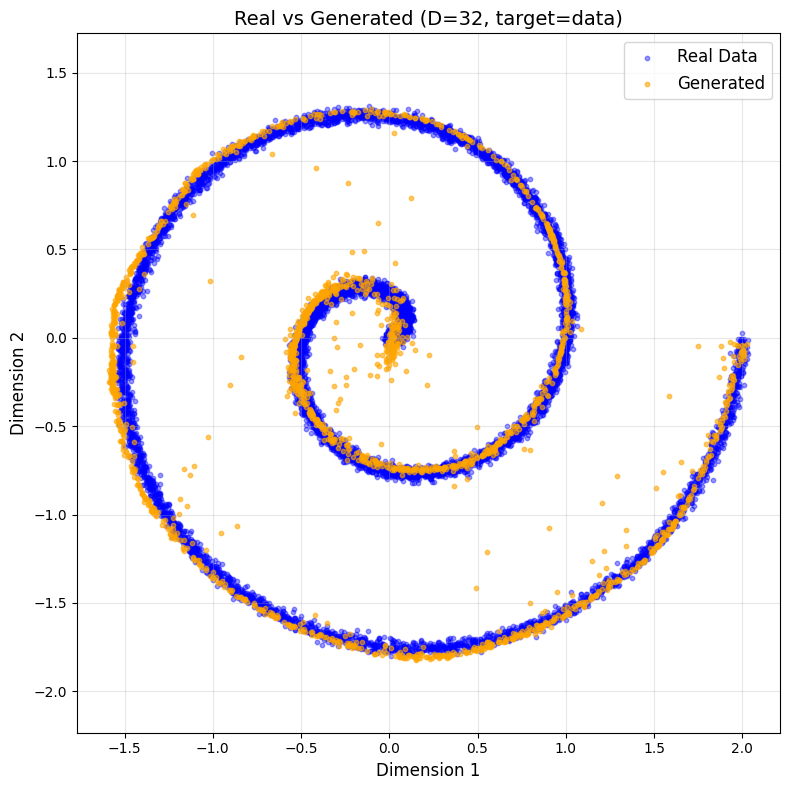


sampling - optimized Schedule
Sampling with async schedule:
  D=32, M=10, steps=10
  Target type: data
  Generating 2000 samples
Sampling complete!


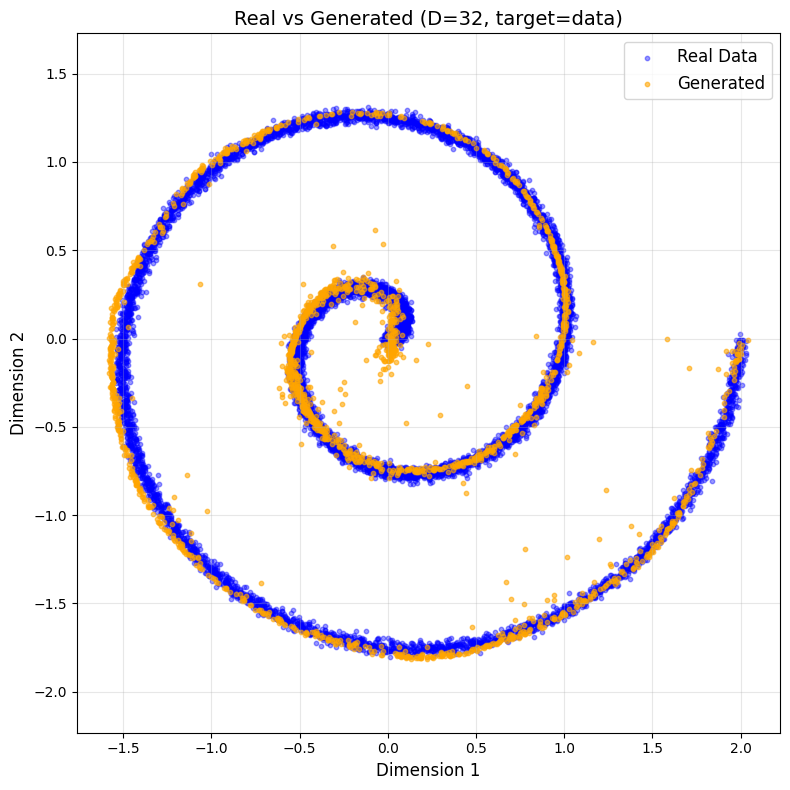

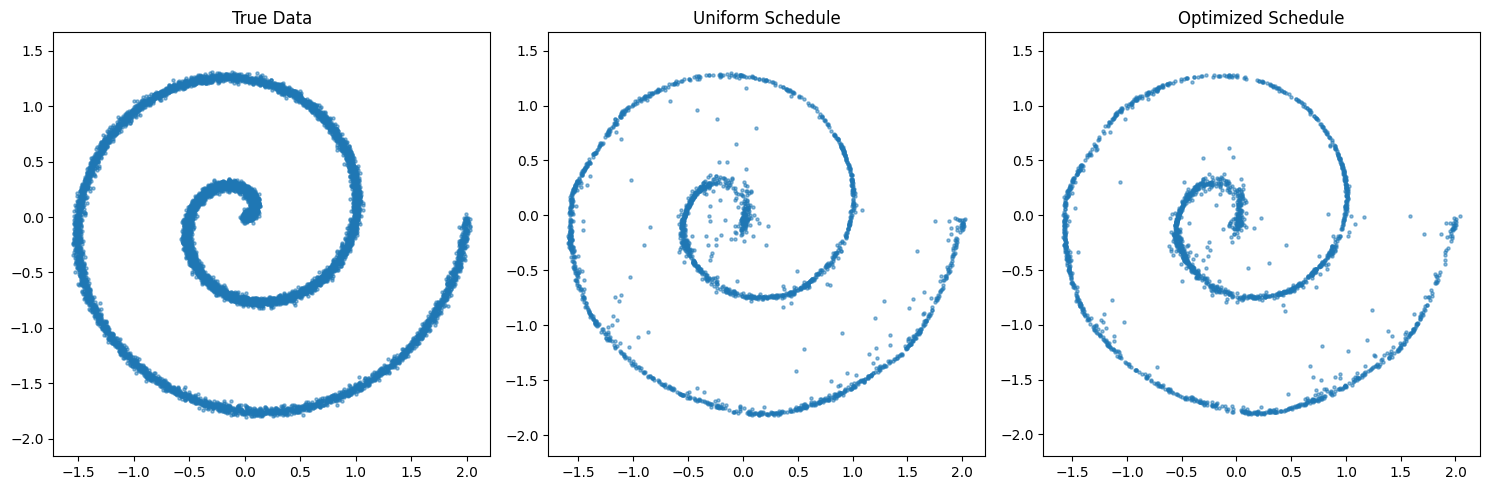

In [20]:
compare_schedules(model_data, P, t_uniform = t_default, t_optimized = t_optimized, x_true = x_hat, sigma = sigma,
                     n_points=2000, target_type="data", steps=10)

In [21]:
t_optimized

tensor([[0.0000, 0.0284, 0.1788, 0.2911, 0.4035, 0.5052, 0.6085, 0.7158, 0.7982,
         0.9120, 1.0000],
        [0.0000, 0.0201, 0.1780, 0.2913, 0.4040, 0.5056, 0.6083, 0.7145, 0.7918,
         0.9058, 1.0000],
        [0.0000, 0.0188, 0.1775, 0.2906, 0.4032, 0.5048, 0.6080, 0.7152, 0.7960,
         0.9041, 1.0000],
        [0.0000, 0.1348, 0.2111, 0.3070, 0.4008, 0.4999, 0.5985, 0.6977, 0.7624,
         0.8878, 1.0000],
        [0.0000, 0.1164, 0.2026, 0.3022, 0.4025, 0.5025, 0.6020, 0.7017, 0.7650,
         0.8792, 1.0000],
        [0.0000, 0.1008, 0.1963, 0.2982, 0.4002, 0.5017, 0.6043, 0.7089, 0.7849,
         0.9049, 1.0000],
        [0.0000, 0.0131, 0.1748, 0.2898, 0.4034, 0.5058, 0.6100, 0.7198, 0.8158,
         0.9134, 1.0000],
        [0.0000, 0.0432, 0.1817, 0.2920, 0.4029, 0.5044, 0.6065, 0.7112, 0.7897,
         0.9137, 1.0000],
        [0.0000, 0.1143, 0.2037, 0.3013, 0.4015, 0.5015, 0.6005, 0.6958, 0.8050,
         0.8939, 1.0000],
        [0.0000, 0.1377, 0.2085, 0.30

## 3.2 Observe the visualization when targeting v

In [22]:
model_v, P, x_hat, x, sigma = train_toy(
    D=32, d=2, target_type="v",
    n_samples=10000, batch_size=1024,
    epochs=500, lr=1e-3
)

x_1 = x / sigma

Data std: 0.2042
Using sigma: 0.0681
Data shape: torch.Size([10000, 32])


Training D=32, target=v:   0%|          | 1/500 [00:00<01:20,  6.20it/s]

[D=32] Epoch 1/500 | v-prediction loss: 7.1246


Training D=32, target=v:  10%|█         | 51/500 [00:07<01:00,  7.37it/s]

[D=32] Epoch 50/500 | v-prediction loss: 1.1739


Training D=32, target=v:  20%|██        | 101/500 [00:14<00:58,  6.83it/s]

[D=32] Epoch 100/500 | v-prediction loss: 0.9372


Training D=32, target=v:  30%|███       | 151/500 [00:21<00:49,  7.05it/s]

[D=32] Epoch 150/500 | v-prediction loss: 0.7924


Training D=32, target=v:  40%|████      | 201/500 [00:29<00:42,  6.97it/s]

[D=32] Epoch 200/500 | v-prediction loss: 0.7050


Training D=32, target=v:  50%|█████     | 251/500 [00:36<00:36,  6.88it/s]

[D=32] Epoch 250/500 | v-prediction loss: 0.6367


Training D=32, target=v:  60%|██████    | 301/500 [00:44<00:30,  6.57it/s]

[D=32] Epoch 300/500 | v-prediction loss: 0.5560


Training D=32, target=v:  70%|███████   | 350/500 [00:51<00:20,  7.16it/s]

[D=32] Epoch 350/500 | v-prediction loss: 0.4947


Training D=32, target=v:  80%|████████  | 401/500 [00:58<00:14,  6.97it/s]

[D=32] Epoch 400/500 | v-prediction loss: 0.4703


Training D=32, target=v:  90%|█████████ | 451/500 [01:05<00:06,  7.12it/s]

[D=32] Epoch 450/500 | v-prediction loss: 0.4500


Training D=32, target=v: 100%|██████████| 500/500 [01:13<00:00,  6.84it/s]

[D=32] Epoch 500/500 | v-prediction loss: 0.4214


In [23]:
t_optimized, history = learning(
    x_1=x_1,
    M = 10,
    model=model_v,
    epoch=50,
    learning_rate=0.001,
    fixed_x0=True,
    subsample=5000,
    loss_freq=1,
    eps = 0.05,
    target_type = "v",
)

print("\n=== Checking Constraints ===")
D, M_plus_1 = t_optimized.shape
M = M_plus_1 - 1
for i in [0, M//2, M]:
    sum_i = t_optimized[:, i].sum().item()
    target = i * D / M
    print(f"Step {i}: sum={sum_i:.6f}, target={target:.6f}")


Using 5000/10000 samples for optimization
Target type: v
  Model predicts: velocity v
  Weight formula: t / (1-t)
Schedule shape: torch.Size([32, 11]) (D=32, M=10)
Safe ratio: 1.0 (optimizing only first 10/10 steps)
Loss frequency: every 1 epochs
Initial loss: 61.101006



Optimizing:   2%|▏         | 1/50 [00:00<00:14,  3.27it/s]

Epoch 1/50 (odd) | Loss: 60.763550


Optimizing:   4%|▍         | 2/50 [00:00<00:13,  3.59it/s]

Epoch 2/50 (even) | Loss: 60.731831


Optimizing:   6%|▌         | 3/50 [00:00<00:13,  3.43it/s]

Epoch 3/50 (odd) | Loss: 60.439217


Optimizing:   8%|▊         | 4/50 [00:01<00:13,  3.51it/s]

Epoch 4/50 (even) | Loss: 60.406265


Optimizing:  10%|█         | 5/50 [00:01<00:13,  3.41it/s]

Epoch 5/50 (odd) | Loss: 60.137016


Optimizing:  12%|█▏        | 6/50 [00:01<00:12,  3.55it/s]

Epoch 6/50 (even) | Loss: 60.104168


Optimizing:  14%|█▍        | 7/50 [00:02<00:12,  3.51it/s]

Epoch 7/50 (odd) | Loss: 59.847397


Optimizing:  16%|█▌        | 8/50 [00:02<00:11,  3.64it/s]

Epoch 8/50 (even) | Loss: 59.814911


Optimizing:  18%|█▊        | 9/50 [00:02<00:11,  3.59it/s]

Epoch 9/50 (odd) | Loss: 59.566956


Optimizing:  20%|██        | 10/50 [00:02<00:10,  3.68it/s]

Epoch 10/50 (even) | Loss: 59.534210


Optimizing:  22%|██▏       | 11/50 [00:03<00:10,  3.58it/s]

Epoch 11/50 (odd) | Loss: 59.293468


Optimizing:  24%|██▍       | 12/50 [00:03<00:10,  3.71it/s]

Epoch 12/50 (even) | Loss: 59.261108


Optimizing:  26%|██▌       | 13/50 [00:03<00:10,  3.63it/s]

Epoch 13/50 (odd) | Loss: 59.028404


Optimizing:  28%|██▊       | 14/50 [00:03<00:09,  3.72it/s]

Epoch 14/50 (even) | Loss: 58.996262


Optimizing:  30%|███       | 15/50 [00:04<00:09,  3.54it/s]

Epoch 15/50 (odd) | Loss: 58.771713


Optimizing:  32%|███▏      | 16/50 [00:04<00:09,  3.67it/s]

Epoch 16/50 (even) | Loss: 58.739849


Optimizing:  34%|███▍      | 17/50 [00:04<00:09,  3.57it/s]

Epoch 17/50 (odd) | Loss: 58.522591


Optimizing:  36%|███▌      | 18/50 [00:05<00:08,  3.67it/s]

Epoch 18/50 (even) | Loss: 58.491005


Optimizing:  38%|███▊      | 19/50 [00:05<00:08,  3.58it/s]

Epoch 19/50 (odd) | Loss: 58.278564


Optimizing:  40%|████      | 20/50 [00:05<00:08,  3.70it/s]

Epoch 20/50 (even) | Loss: 58.246983


Optimizing:  42%|████▏     | 21/50 [00:05<00:08,  3.60it/s]

Epoch 21/50 (odd) | Loss: 58.038322


Optimizing:  44%|████▍     | 22/50 [00:06<00:07,  3.70it/s]

Epoch 22/50 (even) | Loss: 58.007011


Optimizing:  46%|████▌     | 23/50 [00:06<00:07,  3.62it/s]

Epoch 23/50 (odd) | Loss: 57.802788


Optimizing:  48%|████▊     | 24/50 [00:06<00:06,  3.75it/s]

Epoch 24/50 (even) | Loss: 57.771652


Optimizing:  50%|█████     | 25/50 [00:06<00:06,  3.65it/s]

Epoch 25/50 (odd) | Loss: 57.571636


Optimizing:  52%|█████▏    | 26/50 [00:07<00:06,  3.79it/s]

Epoch 26/50 (even) | Loss: 57.540638


Optimizing:  54%|█████▍    | 27/50 [00:07<00:06,  3.69it/s]

Epoch 27/50 (odd) | Loss: 57.343662


Optimizing:  56%|█████▌    | 28/50 [00:07<00:05,  3.82it/s]

Epoch 28/50 (even) | Loss: 57.312782


Optimizing:  58%|█████▊    | 29/50 [00:07<00:05,  3.69it/s]

Epoch 29/50 (odd) | Loss: 57.120148


Optimizing:  60%|██████    | 30/50 [00:08<00:05,  3.79it/s]

Epoch 30/50 (even) | Loss: 57.089115


Optimizing:  62%|██████▏   | 31/50 [00:08<00:05,  3.68it/s]

Epoch 31/50 (odd) | Loss: 56.900581


Optimizing:  64%|██████▍   | 32/50 [00:08<00:04,  3.78it/s]

Epoch 32/50 (even) | Loss: 56.869720


Optimizing:  66%|██████▌   | 33/50 [00:09<00:04,  3.62it/s]

Epoch 33/50 (odd) | Loss: 56.685669


Optimizing:  68%|██████▊   | 34/50 [00:09<00:04,  3.51it/s]

Epoch 34/50 (even) | Loss: 56.654747


Optimizing:  70%|███████   | 35/50 [00:09<00:04,  3.22it/s]

Epoch 35/50 (odd) | Loss: 56.474335


Optimizing:  72%|███████▏  | 36/50 [00:10<00:04,  3.22it/s]

Epoch 36/50 (even) | Loss: 56.443539


Optimizing:  74%|███████▍  | 37/50 [00:10<00:04,  3.00it/s]

Epoch 37/50 (odd) | Loss: 56.265587


Optimizing:  76%|███████▌  | 38/50 [00:10<00:03,  3.21it/s]

Epoch 38/50 (even) | Loss: 56.234806


Optimizing:  78%|███████▊  | 39/50 [00:11<00:03,  3.17it/s]

Epoch 39/50 (odd) | Loss: 56.059685


Optimizing:  80%|████████  | 40/50 [00:11<00:03,  3.29it/s]

Epoch 40/50 (even) | Loss: 56.029053


Optimizing:  82%|████████▏ | 41/50 [00:11<00:02,  3.20it/s]

Epoch 41/50 (odd) | Loss: 55.891476


Optimizing:  84%|████████▍ | 42/50 [00:11<00:02,  3.25it/s]

Epoch 42/50 (even) | Loss: 55.860718


Optimizing:  86%|████████▌ | 43/50 [00:12<00:02,  3.09it/s]

Epoch 43/50 (odd) | Loss: 55.726273


Optimizing:  88%|████████▊ | 44/50 [00:12<00:01,  3.21it/s]

Epoch 44/50 (even) | Loss: 55.695526


Optimizing:  90%|█████████ | 45/50 [00:12<00:01,  3.24it/s]

Epoch 45/50 (odd) | Loss: 55.560024


Optimizing:  92%|█████████▏| 46/50 [00:13<00:01,  3.36it/s]

Epoch 46/50 (even) | Loss: 55.529301


Optimizing:  94%|█████████▍| 47/50 [00:13<00:00,  3.31it/s]

Epoch 47/50 (odd) | Loss: 55.394295


Optimizing:  96%|█████████▌| 48/50 [00:13<00:00,  3.42it/s]

Epoch 48/50 (even) | Loss: 55.363495


Optimizing:  98%|█████████▊| 49/50 [00:14<00:00,  3.29it/s]

Epoch 49/50 (odd) | Loss: 55.229599


Optimizing: 100%|██████████| 50/50 [00:14<00:00,  3.48it/s]

Epoch 50/50 (even) | Loss: 55.198654



Final loss (full 10000 samples): 55.393639
Final loss (subsample): 55.198654
Sum constraints: [0.0, 16.0, 32.0]

=== Checking Constraints ===
Step 0: sum=0.000000, target=0.000000
Step 5: sum=16.000000, target=16.000000
Step 10: sum=32.000000, target=32.000000


In [24]:
t_default = torch.tensor([[i/M for i in range(M+1)]]*D)
t_default

tensor([[0.0000, 0.1000, 0.2000, 0.3000, 0.4000, 0.5000, 0.6000, 0.7000, 0.8000,
         0.9000, 1.0000],
        [0.0000, 0.1000, 0.2000, 0.3000, 0.4000, 0.5000, 0.6000, 0.7000, 0.8000,
         0.9000, 1.0000],
        [0.0000, 0.1000, 0.2000, 0.3000, 0.4000, 0.5000, 0.6000, 0.7000, 0.8000,
         0.9000, 1.0000],
        [0.0000, 0.1000, 0.2000, 0.3000, 0.4000, 0.5000, 0.6000, 0.7000, 0.8000,
         0.9000, 1.0000],
        [0.0000, 0.1000, 0.2000, 0.3000, 0.4000, 0.5000, 0.6000, 0.7000, 0.8000,
         0.9000, 1.0000],
        [0.0000, 0.1000, 0.2000, 0.3000, 0.4000, 0.5000, 0.6000, 0.7000, 0.8000,
         0.9000, 1.0000],
        [0.0000, 0.1000, 0.2000, 0.3000, 0.4000, 0.5000, 0.6000, 0.7000, 0.8000,
         0.9000, 1.0000],
        [0.0000, 0.1000, 0.2000, 0.3000, 0.4000, 0.5000, 0.6000, 0.7000, 0.8000,
         0.9000, 1.0000],
        [0.0000, 0.1000, 0.2000, 0.3000, 0.4000, 0.5000, 0.6000, 0.7000, 0.8000,
         0.9000, 1.0000],
        [0.0000, 0.1000, 0.2000, 0.30

sampling - uniform Schedule
Sampling with async schedule:
  D=32, M=10, steps=250
  Target type: v
  Generating 2000 samples
Sampling complete!


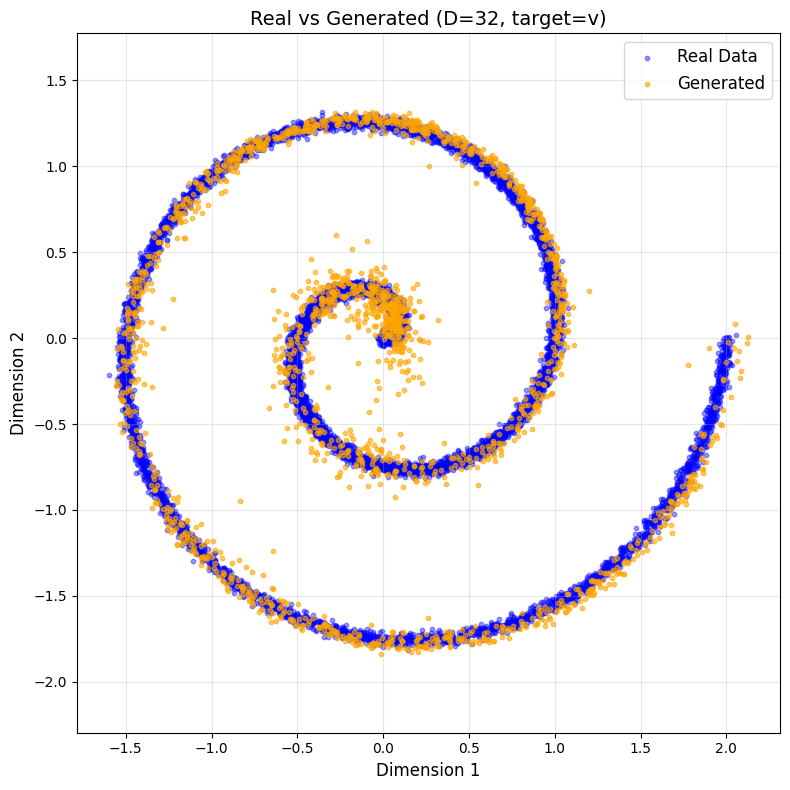


sampling - optimized Schedule
Sampling with async schedule:
  D=32, M=10, steps=250
  Target type: v
  Generating 2000 samples
Sampling complete!


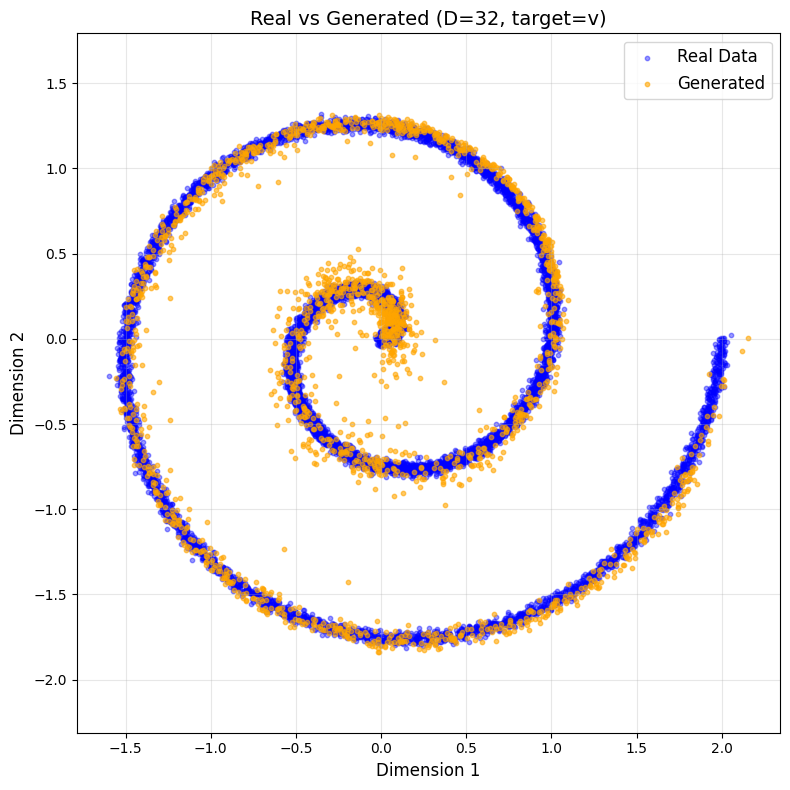

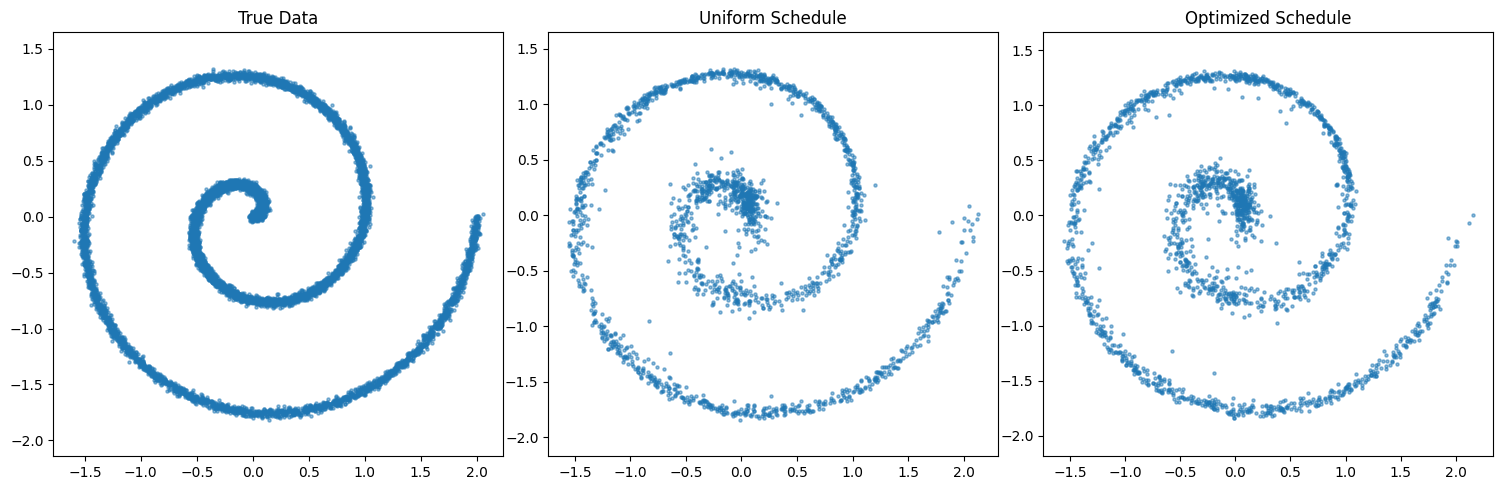

In [25]:
compare_schedules(model_v, P, t_uniform = t_default, t_optimized = t_optimized, x_true = x_hat, sigma = sigma,
                     n_points=2000, target_type="v")